### Assignment 4 by Joan Plepi (matr: 3056655) and Agajan Torayev (matr: 3067341)

In [0]:
from time import time
import torch
import torch.nn as nn
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x578cc000 @  0x7f68e63432a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [4]:
torch.cuda.is_available()

True

### Gets the train and test loaders

In [0]:
def get_train_test_loader(trainset, testset, batch_size):

    # Making dataset iterable
    train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                               batch_size=batch_size,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=testset,
                                              batch_size=batch_size,
                                              shuffle=False)

    return train_loader, test_loader

### Utility function, splits data in k folds

In [0]:
'''
    Parameters:
    - k, number of folds
    - trainset, the training set
    - batch size
'''
def split_data_in_k_folds(k, trainset, batch_size):
    patterns_per_fold = len(trainset) / k

    samplers = []
    for i in range(k):
        samplers.append(SubsetRandomSampler(np.arange(i * patterns_per_fold, (i + 1) * patterns_per_fold, dtype=np.int32)))

    all_data_folds = []

    for sampler in samplers:
        all_data_folds.append(
            torch.utils.data.DataLoader(dataset=trainset,
                                        batch_size=batch_size,
                                        sampler=sampler,
                                        shuffle=False)
        )

    return all_data_folds

## Defining CNN model

In [0]:
'''
in_dim -> cifar case 32x32. I am supposing those are square matrix.
d -> stands for depth.
f -> kernel size
s -> stride
p -> padding size
'''
class CNNModel(nn.Module):
    def __init__(self, **params):
        super(CNNModel, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=params['d1'], out_channels=params['d2'], kernel_size=params['f1'],
                              stride=params['s1'], padding=params['p1'])
        # Activation 1
        self.relu1 = nn.ReLU()
        
        # Convolution 2
        self.cnn2 =  nn.Conv2d(in_channels=params['d2'], out_channels=params['d3'], kernel_size=params['f2'],
                              stride=params['s2'], padding=params['p2'])
        # Activation 2
        self.relu2 = nn.ReLU()
        
        # Max pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # comment up and uncomment below to check the avg pooling. 
        #self.maxpool1 = nn.AvgPool2d(kernel_size=2)      
        
        self.W2 = (params['in_dim'] - params['f1'] + 2*params['p1'])/params['s1'] + 1
        
        self.W3 = (self.W2 - params['f2'] + 2*params['p2'])/params['s2'] + 1

        self.out_dim = params['d3'] * ((self.W3/2) ** 2)
        print("For debugging, W2={}, self.W3={} out {}"
              .format(self.W2,self.W3, self.out_dim))

        # Fully connected layer
        self.fc1 = nn.Linear(int(self.out_dim), params['h1'])
        self.fc1_Relu = nn.ReLU()
        self.fc2 = nn.Linear(params['h1'], 10)

    def forward(self, x):
        # Convolution and activation 1
        out1 = self.cnn1(x)
        out = self.relu1(out1)

        # Convolution and activation 1
        out2 = self.cnn2(out)
        out = self.relu2(out2)

        # Max pooling 2
        out = self.maxpool1(out)

        # Reshaping to pass it to fc1
        out = out.view(out.size(0), -1)
        # Fully connected layer
        out = self.fc1(out)
        out = self.fc1_Relu(out)
        out = self.fc2(out)
        
        return out, out1, out2

## Train **function**

In [0]:
'''
    Parameters:
        - criterion, loss function
        - input dimension
        - a numpy array which will save the loss for every epoch
        - the model
        - number of epochs
        - an optimizer
        - and the train loader to iterate through the patterns     
'''
def train(criterion, model, num_epochs, optimizer, train_loader):
    model.train()
    loss_per_iter = []
    loss_per_epoch = []

    for epoch in range(num_epochs):
        tic = time()
        loss_acc_per_epoch = 0
        
        for i, (images, labels) in enumerate(train_loader):
            
            # send to device
            images, labels = images.to(device), labels.to(device)

            # Clearing the gradients.
            optimizer.zero_grad()
            
            # Forward pass
            outputs, outConv1, outConv2 = model(images)

            # Here the loss function is applied.
            loss = criterion(outputs, labels)

            # We accumulate the loss till the end of the epoch
            loss_acc_per_epoch += loss
            loss_per_iter.append(loss)

            loss.backward()

            optimizer.step()
        loss_per_epoch.append(loss_acc_per_epoch/i)
        print("Finished epoch {:d}/{:d}  in {:f} sec. Loss is {:f}".format(epoch+1, num_epochs, time() - tic, loss_acc_per_epoch/i))
        
    return loss_per_epoch, loss_per_iter, outConv1, outConv2

## Test function

In [0]:
def test(model, test_loader):
    model.eval()
    # Calculate Accuracy
    correct = 0
    total = 0
    # Iterate through test dataset
    with torch.no_grad():
        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)
            # Forward pass only to get logits/output
            outputs, _, _ = model(images)
            # Get predictions from the maximum value
            # it returns the values and the indices of max values per row.
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted.cpu() == labels.cpu()).sum()

    accuracy = 100 * correct / total

    #print('Accuracy: {}'.format(accuracy))
    return accuracy.item()

## Weight initalizer

In [0]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

### Loading the data setting, setting batch size and seed

In [12]:
''' Loading the dataset '''
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

''' Defining batch size and number of iterations and number of epochs based on those'''
batch_size = 100

# setting the seed
torch.manual_seed(1)

# setting input and output dimensions
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
input_dim = 3 * 32 * 32
output_dim = len(CLASSES)

Files already downloaded and verified


# Cross Validation 

In [0]:
# choose default parameters
hyperparameter_ranges = {
    'momentum' : [0.4, 0.6, 0.8],
    'wd' : [1e-4, 1e-3, 1e-5, 0],
    'lr' : [0.05, 0.01, 0.005, 0.001],
    'd2' : [16,24,32],
    'd3' : [32, 38, 44, 50],
    'p2' : [0, 1],
    'h1' : [500, 1000, 1500]
}

parameters = {
    'in_dim': 32, 
    'd1' : 3,
    'f1' : 3,
    's1' : 1,
    'p1' : 0,
    'f2' : 3,
    's2' : 1,
    'd2' : 32,
    'd3' : 50,
    'p2' : 1,
    'h1' : 1000
}

                
best_values = {'d2':0, 'd3':0, 'lr':0, 'p2':0, 'h1':0, 'wd':0, 'momentum' : 0}


In [0]:
# get all data folds
all_data_folds = split_data_in_k_folds(5, trainset, 100) # minibatch size 100

best_acc = 0

# setting seed to have the same initialization
torch.manual_seed(1) 

# Outer loop through hyperparameters. 
for momentum in hyperparameter_ranges['momentum']:
    for wd in hyperparameter_ranges['wd']:
        for lr in  hyperparameter_ranges['lr']:
            for d2 in  hyperparameter_ranges['d2']:
                for d3 in  hyperparameter_ranges['d3']:
                    for p2 in  hyperparameter_ranges['p2']:
                        for h1 in  hyperparameter_ranges['h1']:

                            parameters['d2'] = d2
                            parameters['d3'] = d3
                            parameters['p2'] = p2
                            parameters['h1'] = h1

                            model = CNNModel(**parameters)
                            model.to(device)

                            # initializing the array for accuracies for each fold. 
                            accuracies_per_validation = np.zeros(5)
                            accuracies_mean = 0

                            # every fold will serve once as a validation fold.
                            for idx_val_fold in range(len(all_data_folds)):

                                #resetting the weights for each validation
                                model.apply(weight_init)

                                # loading the validation data fold
                                validation_loader = all_data_folds[idx_val_fold]

                                # optimizer
                                optimizer = torch.optim.SGD(model.parameters(), lr=lr,weight_decay=wd, momentum=momentum)

                                for idx_training_fold in range(len(all_data_folds)):

                                    # just to avoid using the current fold for training 
                                    if idx_training_fold != idx_val_fold: 

                                        # loading the data for the current training fold 
                                        train_loader = all_data_folds[idx_training_fold]
                                        # training
                                        train(criterion, model, 5, optimizer,
                                                      train_loader)

                                # validating over the validation fold
                                temp_acc = test(model, validation_loader)
                                accuracies_per_validation[idx_val_fold] = temp_acc

                            accuracies_mean = accuracies_per_validation.mean()

                            print("Acc: {}. Parameter combination {}, {}, {}, {}, {}, {}, {}".format(
                                accuracies_mean, momentum, wd, lr, d2, d3, p2, h1))

                            # save hyperparameter values if accuracy is better than the current best
                            if accuracies_mean > best_acc:
                                best_acc = accuracies_mean
                                best_values['d2'] = d2
                                best_values['d3'] = d3
                                best_values['p2'] = p2
                                best_values['h1'] = h1
                                best_values['lr'] = lr
                                best_values['wd'] = wd
                                best_values['momentum'] = momentum

print(best_values)

## Running the model with best parameters

In [13]:
trainloader, testloader = get_train_test_loader(trainset, testset, batch_size)

# the final ones
parameters = {
    'in_dim': 32, 
    'd1' : 3,
    'd2' : 24,
    'f1' : 3,
    's1' : 1,
    'p1' : 0,
    'd3' : 50,
    'f2' : 3,
    's2' : 1,
    'p2' : 1,
    'h1' : 1500
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNModel(**parameters)
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
torch.manual_seed(1)
model.apply(weight_init)

# learning rate 1e-2, weight decay 1e-3, momemtum term 0.6
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.6)

loss_per_epoch, loss_per_iter, out1, out2 = train(criterion, model, 100, optimizer, trainloader)
test(model, testloader)

For debugging, W2=30.0, self.W3=30.0 out 11250.0
CNNModel(
  (cnn1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (cnn2): Conv2d(24, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11250, out_features=1500, bias=True)
  (fc1_Relu): ReLU()
  (fc2): Linear(in_features=1500, out_features=10, bias=True)
)
Finished epoch 1/100  in 12.603351 sec. Loss is 1.987940
Finished epoch 2/100  in 12.544680 sec. Loss is 1.646737
Finished epoch 3/100  in 12.558317 sec. Loss is 1.446227
Finished epoch 4/100  in 12.560386 sec. Loss is 1.313986
Finished epoch 5/100  in 12.574932 sec. Loss is 1.215636
Finished epoch 6/100  in 12.590665 sec. Loss is 1.126393
Finished epoch 7/100  in 12.609762 sec. Loss is 1.044141
Finished epoch 8/100  in 12.538857 sec. Loss is 0.962688
Finished epoch 9/100  in 12.508159 sec. Loss is 0.874095
Finished epoch 10/

69

### Vizualizing kernel weights

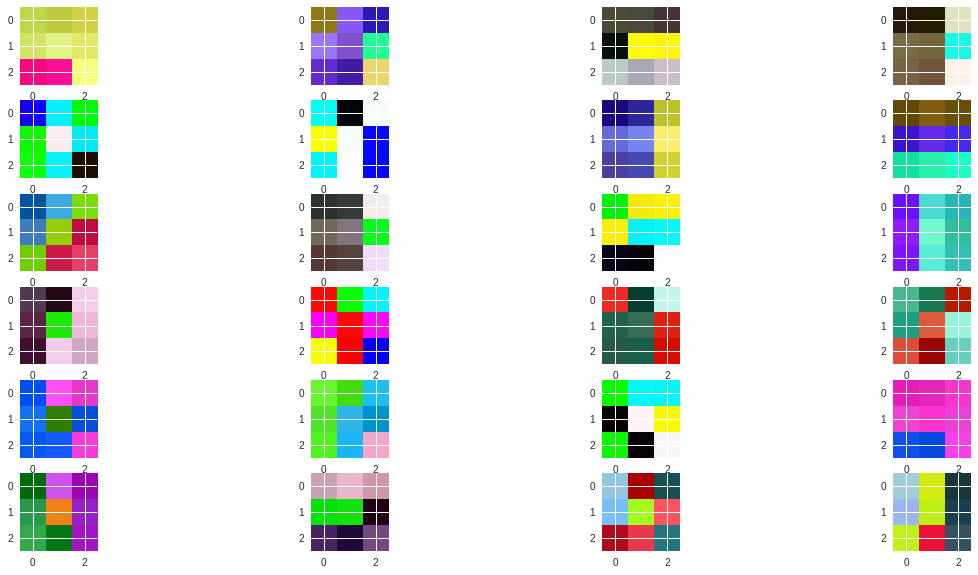

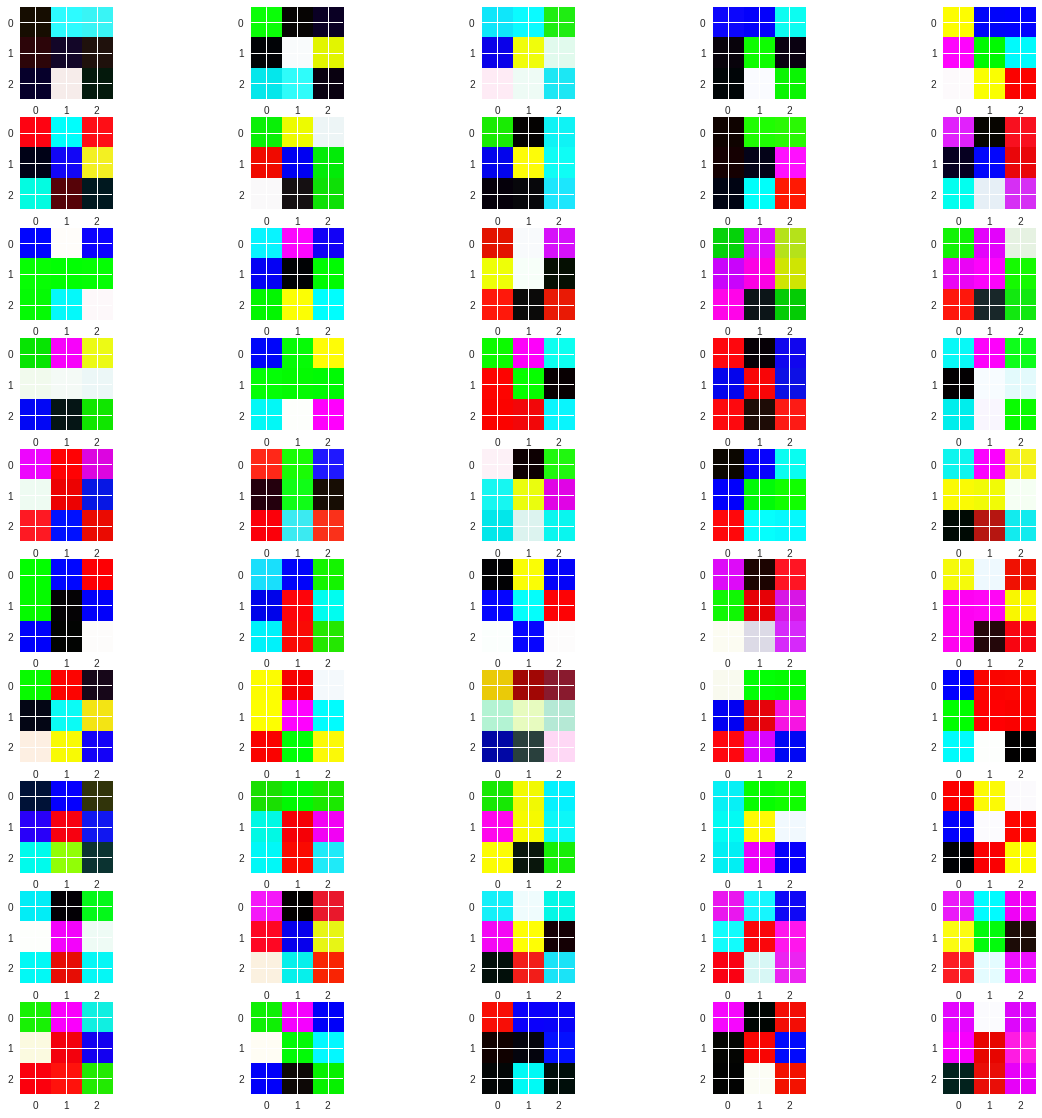

In [30]:
# for the moment only vizualizing the learn kernels. 
with torch.no_grad():
    for param in model.named_parameters():
        if('cnn' in param[0] and 'weight' in param[0]):
            kernels = param[1]
            nr_kern = kernels.size(0)
            if nr_kern%4==0 :
                j = 4
            else: 
                j = 5
                
            figure, axes = plt.subplots(int(nr_kern/j),j)
            if nr_kern < 30:
                fig_width = 20
                fig_height = 10
            else:
                fig_width = 20
                fig_height = 20
            figure.set_figwidth(fig_width)
            figure.set_figheight(fig_height)
            for i in range(kernels.size(0)):
                _to_pil = transforms.ToPILImage()
                axes[int(i/j), i%j].imshow(_to_pil(kernels[i].detach().cpu()))

            plt.show()

### Vizualizing the output of both conv layers. At the moment only for one image of the last minibatch

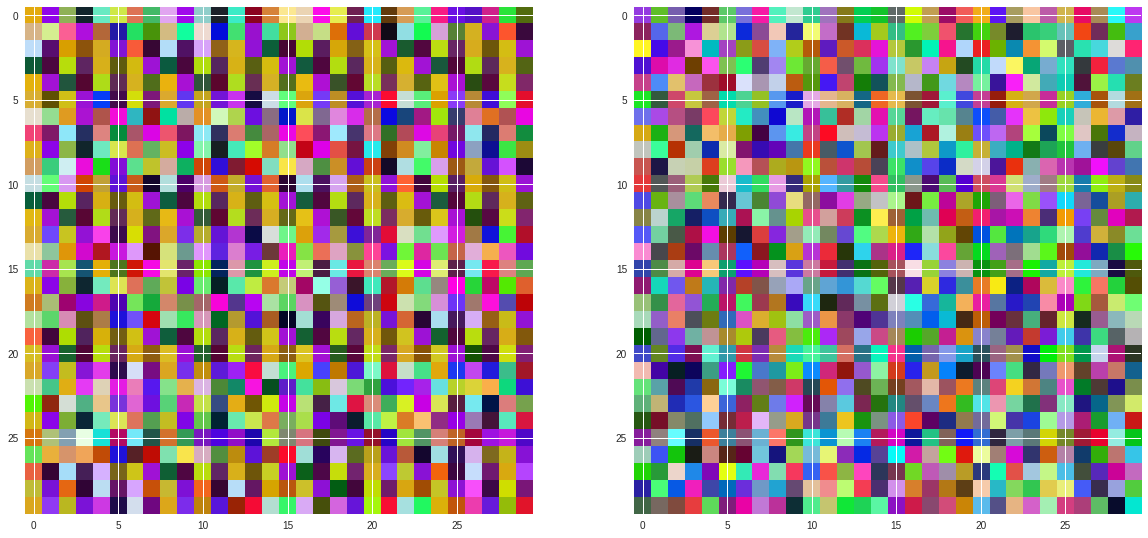

In [34]:
# for the moment only vizualizing the learn kernels. 
with torch.no_grad():
    i = 0 # here we can set up a loop for all the out images of the minibatch.
    _to_pil = transforms.ToPILImage()
    figure, axes = plt.subplots(1,2)
    figure.set_figwidth(20)
    figure.set_figheight(10)
    axes[0].imshow(_to_pil(out1[i].detach().cpu()))
    axes[1].imshow(_to_pil(out2[i].detach().cpu()))
    plt.show()

### The cell below is runned with average pooling. The accuracy is 65%, lower than with max pooling where we got accuracy 69% with the same parameters

In [17]:
trainloader, testloader = get_train_test_loader(trainset, testset, batch_size)

# the final ones
parameters = {
    'in_dim': 32, 
    'd1' : 3,
    'd2' : 24,
    'f1' : 3,
    's1' : 1,
    'p1' : 0,
    'd3' : 50,
    'f2' : 3,
    's2' : 1,
    'p2' : 1,
    'h1' : 1500
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNModel(**parameters)
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
torch.manual_seed(1)
model.apply(weight_init)

# learning rate 1e-2, weight decay 1e-3, momemtum term 0.6
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001, momentum=0.6)

loss_per_epoch, loss_per_iter, out1, out2 = train(criterion, model, 100, optimizer, trainloader)
test(model, testloader)

For debugging, W2=30.0, self.W3=30.0 out 11250.0
CNNModel(
  (cnn1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (cnn2): Conv2d(24, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=11250, out_features=1500, bias=True)
  (fc1_Relu): ReLU()
  (fc2): Linear(in_features=1500, out_features=10, bias=True)
)
Finished epoch 1/100  in 12.816344 sec. Loss is 1.987581
Finished epoch 2/100  in 12.836743 sec. Loss is 1.678896
Finished epoch 3/100  in 12.836189 sec. Loss is 1.538298
Finished epoch 4/100  in 12.781995 sec. Loss is 1.447716
Finished epoch 5/100  in 12.718617 sec. Loss is 1.373834
Finished epoch 6/100  in 12.745469 sec. Loss is 1.304545
Finished epoch 7/100  in 12.767354 sec. Loss is 1.247801
Finished epoch 8/100  in 12.848135 sec. Loss is 1.192057
Finished epoch 9/100  in 12.758014 sec. Loss is 1.134864
Finished epoch 10/100  in 12.770111 sec. Loss i

65